Title: [Practical machine learning (Regression)](https://www.youtube.com/watch?v=lN5jesocJjk&list=PLQVvvaa0QuDfKTOs3Keq_kaG2P55YRn5v&index=3)

## Import libraries and data 


In [66]:
import pandas as pd 
import quandl
import math, datetime
import numpy as np 
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

## Create dataframe and features

In [17]:
data = quandl.get('WIKI/GOOGL')
data.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [18]:
data = data[['Adj. Open', 'Adj. High' , 'Adj. Low', 'Adj. Close', 'Adj. Volume',]]
data.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0


## Create more features to work with


In [19]:
# precent volatility
data['HL_PCT'] = (data['Adj. High'] - data['Adj. Close']) / data['Adj. Close'] * 100.0

# daily percent change
data['PCT_change'] = (data['Adj. Close'] - data['Adj. Open']) / data['Adj. Open'] * 100.0

data.head()


,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,HL_PCT,PCT_change
Date,,,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0,3.712563,0.324968
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0,0.710922,7.227007
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0,3.729433,-1.227880
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0,6.417469,-5.726357
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0,1.886792,1.183658


In [20]:
## drop superfluous features

data1 = data.drop(data.iloc[:, 0:3], axis=1)
data1.head()

,Adj. Close,Adj. Volume,HL_PCT,PCT_change
Date,,,,
2004-08-19,50.322842,44659000.0,3.712563,0.324968
2004-08-20,54.322689,22834300.0,0.710922,7.227007
2004-08-23,54.869377,18256100.0,3.729433,-1.227880
2004-08-24,52.597363,15247300.0,6.417469,-5.726357
2004-08-25,53.164113,9188600.0,1.886792,1.183658


## Problem formulation
The speaker aims to use the previous data points
of adjusted close price to make step ahead prediciton.

In [21]:
forecast_col = 'Adj. Close'

## fill nana with outliers
data1.fillna(-99999, inplace=True)

In [22]:
## make steps ahead forecast with the previous datapoints

forecast_out = int(math.ceil(0.01 * len(data)))

# data1['label'] = data1[forecast_col]

## the data has been shifted up by forecast_out 
data1['label'] = data1[forecast_col].shift(-forecast_out)

## dropping the nans deletes that last(forecast_out) rows
data1.dropna(inplace=True)
data1.head()

,Adj. Close,Adj. Volume,HL_PCT,PCT_change,label
Date,,,,,
2004-08-19,50.322842,44659000.0,3.712563,0.324968,69.078238
2004-08-20,54.322689,22834300.0,0.710922,7.227007,67.839414
2004-08-23,54.869377,18256100.0,3.729433,-1.227880,68.912727
2004-08-24,52.597363,15247300.0,6.417469,-5.726357,70.668146
2004-08-25,53.164113,9188600.0,1.886792,1.183658,71.219849


## Create input and output

In [42]:
print(len(data1))
print(len(X))
print(len(y))

3389
3354
3354


In [43]:
# data1.dropna(inplace=True)

X = np.array(data1.drop(['label'], 1))
X = preprocessing.scale(X)
X = X[:-forecast_out]
X_lately = X[-forecast_out:]



y = np.array(data1['label'])
y = y[:-forecast_out]
# y = np.array(data1['label'])

## Test/Train

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Create classifier

In [45]:
lin_clf = LinearRegression()
svm_clf = svm.SVR(kernel='poly')

clf = lin_clf
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)

## Make predictions

In [68]:
forecast_set = clf.predict(X_lately)
print(forecast_set)
print("")
print(f"The accurary of this classifier is {accuracy}")
print("")
print(f"{forecast_out} predictions were made")

[1013.38846287 1015.97580937 1014.75985003 1054.55655197 1057.75839753
 1057.89614119 1067.5270773  1068.64647305 1075.80308129 1067.92924395
 1078.44067302 1073.40345728 1070.05823638 1066.41077185 1067.56083259
 1062.0432936  1073.87547532 1060.56764399 1060.29519508 1076.13619519
 1077.88477752 1082.47458489 1097.81242774 1088.04445175 1061.08975362
 1061.06332332 1049.37248869 1035.4261225  1042.47938985 1056.99095614
 1069.73533845 1074.78067058 1077.76025892 1073.19595421 1077.15566855]

The accurary of this classifier is 0.9781396231802637

35 predictions were made


In [69]:
## Convert to datetime

In [70]:
data1['Forecast'] = np.nan
last_date = data1.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

In [71]:
for i in forecast_set:
    next_day = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    data1.loc[next_day] = [np.nan for _ in range(len(data1.columns)-1)] + [i]

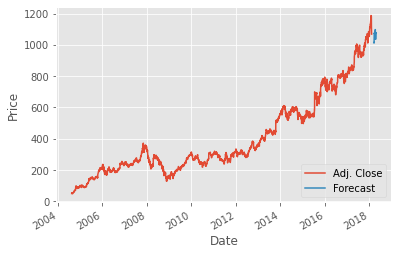

In [76]:
plt.figure(figsize=(16, 8))
data1['Adj. Close'].plot()
data1['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()